# Email Spam Detection

We’ve all been the recipient of spam emails before. Spam mail, or junk mail, is a type of email
that is sent to a massive number of users at one time, frequently containing cryptic
messages, scams, or most dangerously, phishing content.

## 1. Problem Definition

> Given certain set of features, how well can can you classify whether an email is spam or not.

## 2. Data

The original data came from UCI Repository - https://archive.ics.uci.edu/dataset/228/sms+spam+collection <br>

The dataset was downloaded from **Kaggle - SMS Spam Collection Dataset.** <br>
https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

## 3. Evaluation
To accurately separate email/sms(s) in spam and non-spam categories.

## 4. Features

#### Data Dictionary:

* **v1/Spam:** This column indicates whether the message is spam or ham (legitimate). It contains categorical data with two possible values: "ham" or "spam". <br>
* **v2/Text:** This column contains the raw text of the SMS messages. It includes both spam and ham messages. It contains textual data. <br>

This dataset comprises 5,574 SMS messages in English, with each message labeled as either "ham" or "spam". The messages were collected from various sources, including online forums and academic research datasets. The "ham" messages were predominantly sourced from the NUS SMS Corpus and Caroline Tag's PhD Thesis, while the "spam" messages were collected manually from the Grumbletext website and the SMS Spam Corpus v.0.1 Big.

In [1]:
# Importing necessary tools

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv("data/spam.csv", encoding='latin-1')

In [3]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
data.shape

(5572, 5)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
data.duplicated().sum()

403

##### The data has 403 rows of duplicate rows. Therefore, we will drop duplicated data for data preprocessing.

In [7]:
data.drop_duplicates(inplace=True)

In [8]:
data.shape

(5169, 5)

In [9]:
data.isna().sum()

v1               0
v2               0
Unnamed: 2    5126
Unnamed: 3    5159
Unnamed: 4    5164
dtype: int64

##### We can see all the unnamed columns have null values. Therefore dropping unnamed columns.

In [10]:
data.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)
data.shape

(5169, 2)

In [11]:
data.isnull().sum()

v1    0
v2    0
dtype: int64

In [12]:
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
data.rename(columns={'v1':'Spam','v2':'Text'},inplace=True)
data.head()

,Spam,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
data.info

<bound method DataFrame.info of       Spam                                               Text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham              Will Ì_ b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5169 rows x 2 columns]>

In [15]:
data['Spam'].value_counts()

Spam
ham     4516
spam     653
Name: count, dtype: int64

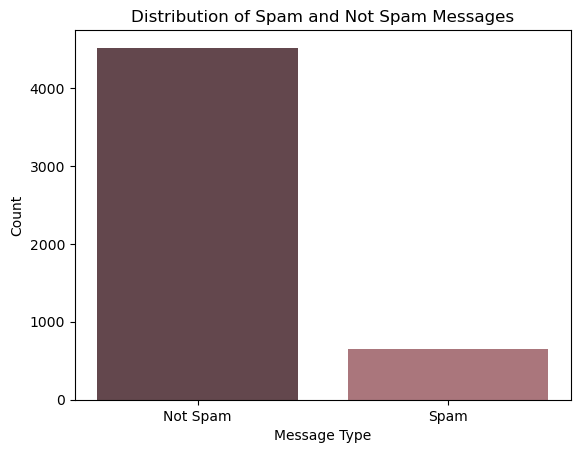

In [16]:
# Count occurrences of 'ham' and 'spam'
ham_count = data['Spam'].value_counts()['ham']
spam_count = data['Spam'].value_counts()['spam']

# Plotting
labels = ['Not Spam', 'Spam']
counts = [ham_count, spam_count]

plt.bar(labels, counts, color=['#63474D', '#AA767C'])
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.title('Distribution of Spam and Not Spam Messages')
plt.show()

As we can observe, the dataset is imbalanced with maximum data being classfied as 'ham' or 'not spam'. <br> To solve this, we create two separate datasets containing 'ham' texts and 'spam' texts.

In [17]:
ham_texts = data[data.Spam=='ham']
spam_texts= data[data.Spam=='spam']

print(f"Ham shape:{ham_texts.shape}") 
print(f"Spam shape: {spam_texts.shape}")

Ham shape:(4516, 2)
Spam shape: (653, 2)


In [18]:
ham_sample = ham_texts.sample(n=653)

In [19]:
ham_sample.shape, spam_texts.shape

((653, 2), (653, 2))

In [20]:
balanced_data = pd.concat([ham_sample,spam_texts],axis=0)
balanced_data.shape

(1306, 2)

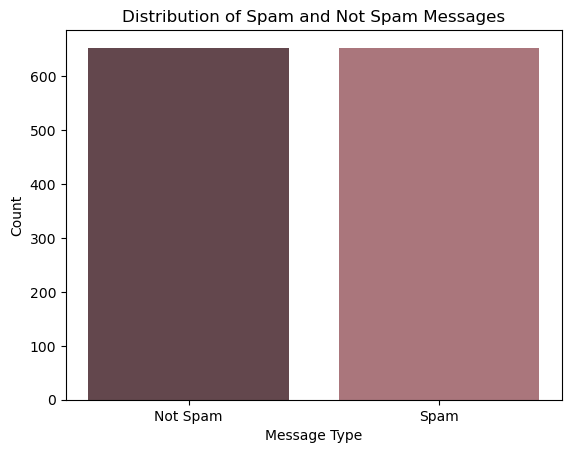

In [21]:
# Count occurrences of 'ham' and 'spam'
ham_count = ham_sample.shape[0]
spam_count = spam_texts.shape[0]

# Plotting
labels = ['Not Spam', 'Spam']
counts = [ham_count, spam_count]

plt.bar(labels, counts, color=['#63474D', '#AA767C'])
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.title('Distribution of Spam and Not Spam Messages')
plt.show()


##### Since now we have equal number of data for not spam and spam.
##### Therefore, we'll encode the 'Ham' and 'Spam' values as 0 and 1 respectively.

In [22]:
balanced_data['Spam'].replace({'ham':0,'spam':1},inplace=True)
balanced_data

,Spam,Text
1033,0,"OH MR SHEFFIELD! You wanna play THAT game, oka..."
2781,0,Then its most likely called Mittelschmertz. Go...
3477,0,I can ask around but there's not a lot in term...
5023,0,Where you. What happen
2931,0,Only 2% students solved this CAT question in '...
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


## 5. Modelling:
We've done enough EDA (could do more ofc), but proceeding towards model-driven EDA.

#### Splitting into training and testing datasets.

In [23]:
vectorizer = TfidfVectorizer()

In [24]:
X=vectorizer.fit_transform(balanced_data['Text'])
y=balanced_data['Spam']

In [25]:
print(X)

  (0, 2881)	0.17025755029879144
  (0, 2462)	0.16325757335436267
  (0, 3183)	0.27226547756513647
  (0, 2593)	0.1251480100884777
  (0, 1956)	0.3667880145936373
  (0, 2756)	0.27226547756513647
  (0, 862)	0.21085781608737764
  (0, 1106)	0.27226547756513647
  (0, 3827)	0.18836044563323492
  (0, 3198)	0.17495927220245502
  (0, 2869)	0.22668027394928117
  (0, 1917)	0.2102335602330296
  (0, 3825)	0.13374966167904434
  (0, 3022)	0.19231345769666008
  (0, 4163)	0.19659931527539937
  (0, 4348)	0.31500460215187004
  (0, 3445)	0.27226547756513647
  (0, 2709)	0.23892373564409974
  (0, 2863)	0.2041548409096312
  (1, 1966)	0.1727781602133388
  (1, 4239)	0.15454360946104548
  (1, 4286)	0.2570963427895477
  (1, 2943)	0.3087981910834823
  (1, 2060)	0.12743814992329103
  (1, 1597)	0.39976723950218657
  :	:
  (1305, 2837)	0.29345684822523127
  (1305, 164)	0.29345684822523127
  (1305, 3082)	0.2503693661660506
  (1305, 615)	0.2051613722115433
  (1305, 306)	0.19941159621758087
  (1305, 1404)	0.165674574554079

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,
                                                 random_state=42)

#### Training the dataset on Logisitic Regression Model

In [27]:
model = LogisticRegression()

In [28]:
model.fit(X_train, y_train)

LogisticRegression()

In [29]:
y_preds = model.predict(X_train)

In [30]:
print(y_preds)

[1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0
 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 0 1 0
 0 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 1 0 1 0 0 1 0
 0 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1
 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0
 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0
 1 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1
 0 1 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0
 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1
 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 0 0 0 1 0 1 1 1
 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0
 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 0 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1
 1 0 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 0 0 1
 0 1 1 0 0 0 0 1 1 0 1 0 

In [31]:
train_accuracy = accuracy_score(y_train,y_preds)
print(train_accuracy)

0.9836567926455567


In [32]:
test_predict = model.predict(X_test)
print(test_predict)

[1 0 1 0 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 0
 1 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 1
 0 0 0 0 1 1 1 1 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 1 1 0 1 0 0 0 1 0 1 0 0 0
 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 0
 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1
 1 1 0 1 0 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0
 1 0 1 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0
 0 1 1 1 0 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 1 0 1 1 0 1 1]


In [33]:
test_accuracy=accuracy_score(y_test,test_predict)
print(test_accuracy)

0.9388379204892966


In [34]:
report = classification_report(y_test,test_predict)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       170
           1       0.97      0.90      0.93       157

    accuracy                           0.94       327
   macro avg       0.94      0.94      0.94       327
weighted avg       0.94      0.94      0.94       327

